In [6]:
import torch
from torch import nn
from metann.meta import MAMLpp, mamlpp_evaluator, RMSPropLearner
import data
import torch.optim as optim

In [7]:
def mse_evaluator(model, data):
    x, y = data
    o = model(x)
    return nn.functional.mse_loss(o, y)


def mlp():
    return nn.Sequential(
        nn.Linear(1, 80),
        nn.ReLU(),
        nn.Linear(80, 200),
        nn.ReLU(),
        nn.Linear(200, 200),
        nn.ReLU(),
        nn.Linear(200, 80),
        nn.ReLU(),
        nn.Linear(80, 2),
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = mlp().to(device)
maml = MAMLpp(model, 5, 5, lr=1e-1, evaluator=mse_evaluator)

In [8]:
maml.load_state_dict(torch.load('./saved_models/mppt.pth'))
model.eval()

Sequential(
  (0): Linear(in_features=1, out_features=80, bias=True)
  (1): ReLU()
  (2): Linear(in_features=80, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=200, bias=True)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=80, bias=True)
  (7): ReLU()
  (8): Linear(in_features=80, out_features=2, bias=True)
)

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


df = pd.DataFrame({'mod':[], 'logf':[], 'value':[], 'type':[], 'conf':[],})
data_provider = data.MetaZDataProvider(root='./data/mppt2/test/',
                                       batch_size=[9, 47, 49, 53, 117, 135], 
                                       batch_size_eval=136, 
                                       length=5, sampler='sequence')
maml.eval()

MAMLpp(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=80, bias=True)
    (7): ReLU()
    (8): Linear(in_features=80, out_features=2, bias=True)
  )
)

In [27]:
for i, dataset in enumerate(data_provider):
    (x, y), (x_test, y_test) = dataset
    x = x.to(device)
    y = y.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    model = maml((x, y))
    ys = model(x_test)
    print(mse_evaluator(model, (x_test, y_test)).item())
    for i in range(len(ys)):
        df = df.append({'mod':'out','logf':x_test[i][0].item(), 'value':ys[i][0].item(), 'type':'logr', 'conf':dataset.idx,}, ignore_index=True)
        df = df.append({'mod':'gt','logf':x_test[i][0].item(), 'value':y_test[i][0].item(), 'type':'logr', 'conf':dataset.idx,}, ignore_index=True)
    for i in range(len(ys)):
        df = df.append({'mod':'out','logf':x_test[i][0].item(), 'value':ys[i][0].item(), 'type':'logr', 'conf':'c',}, ignore_index=True)
    for i in range(len(x)):
        df = df.append({'mod':'gt2','logf':x[i][0].item(), 'value':y[i][0].item(), 'type':'logr', 'conf':'c',}, ignore_index=True)

    model_pre = maml.model
    ys = model_pre(x_test)
    for i in range(len(ys)):
        df = df.append({'mod':'out','logf':x_test[i][0].item(), 'value':ys[i][0].item(), 'type':'logr', 'conf':'pre',}, ignore_index=True)

    for i in range(len(ys)):
        df = df.append({'mod':'out','logf':x_test[i][0].item(), 'value':ys[i][0].item(), 'type':'logr', 'conf':'prec',}, ignore_index=True)
    for i in range(len(x)):
        df = df.append({'mod':'gt2','logf':x[i][0].item(), 'value':y[i][0].item(), 'type':'logr', 'conf':'prec',}, ignore_index=True)
        
    break


0.06903591006994247


In [28]:
df = df.sort_values(['conf', 'logf'])

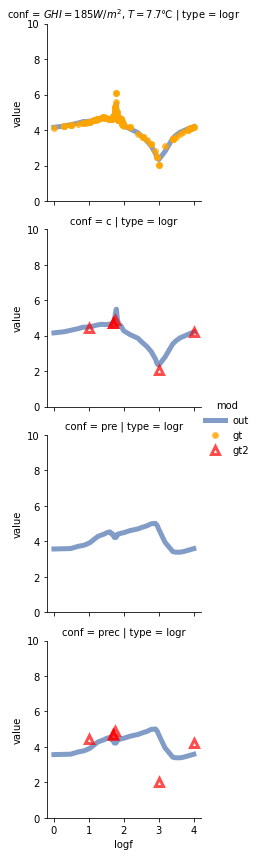

In [37]:
d = {'ls': ['-', '', ''],
#      'c': ['blue', '', ''],
     'marker':['','.','o'],
     'mfc':['','orange',''],
     'mec':['','orange','red'],
     'fillstyle':['none','full','none'],
     'ms':[6,8,8]}
g = sns.FacetGrid(df, row='conf', col="type", hue="mod", hue_kws=d, palette=sns.color_palette("deep"))
g.map(plt.plot, "logf", "value", alpha=.7, lw=5, mew=3)
g.set(ylim=(0, 10))
# g.set(xscale = 'log')
g.add_legend()
fig = g.savefig('out.svg', dpi=400)